## Sales Forecasting with Time Series Data  

**Data source** (Kaggle) : https://www.kaggle.com/datasets/kankanashukla/champagne-data

**Description**: The dataset presents monthly sales of a French champagne in form of a time series. We are required to train a time series forecasting model to predict future sales. 

In [14]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import math

# ignore warnings while running code 
import warnings
warnings.filterwarnings("ignore")

In [15]:
path = r'/Users/akhilmathur/Desktop/python_files/datasets/champagne_sales.csv'
df= pd.read_csv(path)
df.head()

,Month,Sales
0,1964-01,2815
1,1964-02,2672
2,1964-03,2755
3,1964-04,2721
4,1964-05,2946


### Data Cleaning and Stationarity Analysis 

In [16]:
# we have been given monthly sales data i.e. window = 12 
# check for any missing data 
print(f"Total rows with missing data: {df.isnull().sum().sum()}")

Total rows with missing data: 0


<Axes: xlabel='Month'>

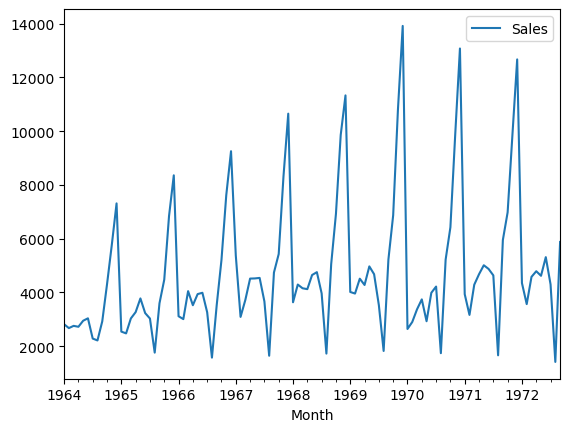

In [17]:
# convert time series column to datetime 
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace = True)

# plot the sales data 
df.plot()

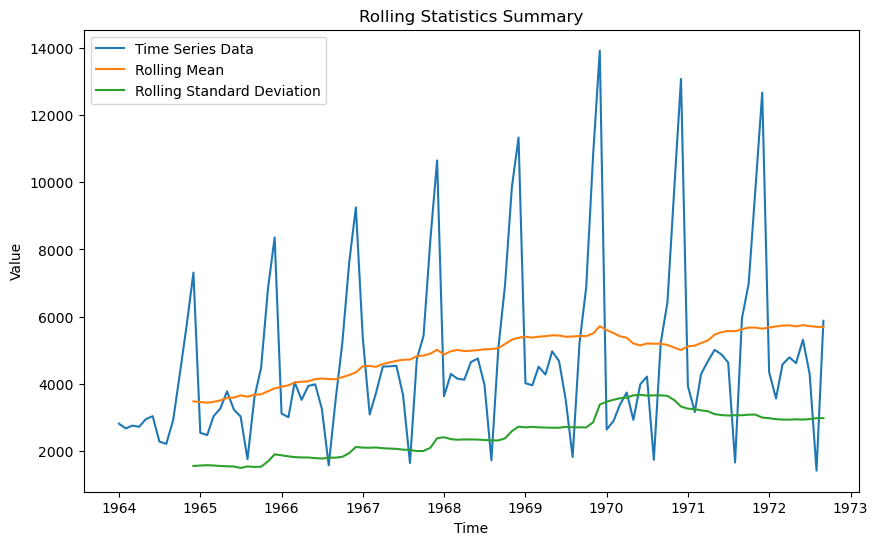

In [18]:
# initial observation shows some seasonality in the dataset - appears to be non-stationary

# write function to perform visual inspection with rolling stats
def check_roll_stats(df):
    roll_mean = df.rolling(window = 12).mean().dropna()
    roll_std = df.rolling(window = 12).std().dropna()
      
    plt.figure(figsize = (10,6))
    plt.plot(df, label='Time Series Data')
    plt.plot(roll_mean, label='Rolling Mean')
    plt.plot(roll_std, label='Rolling Standard Deviation')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Rolling Statistics Summary')
    plt.legend()
    plt.show()


# call the above function 
check_roll_stats(df)
    
# the mean and variance do not seem to be constant - indicates non-stationary data

In [19]:
# confirm the above with a statistical test - we use Augmented Dicky-Fueller test (ADF)
from statsmodels.tsa.stattools import adfuller

def perform_adf(data, p_val_thrsh = 0.05):
    res = adfuller(data)
    res_lbls  = ['test_statistic', 'p-value', 'lags_used', 'no. of observations', 'critical values']
    
    for val,lbl in zip(res,res_lbls):
        print(f"{lbl}:{val}")
    
    # lets keep the p-value threshold at 0.05 to test our hypothesis
    if res[1] < p_val_thrsh:
        print("\nNull-Hypothesis Rejected : Time Series Data is Stationary.")
    else:
        print("\nNull-Hypothesis NOT Rejected : Time Series Data is Non-Stationary. Requires differencing.")

# call the ADF function with our given dataset 
perform_adf(df)

test_statistic:-1.833593056327616
p-value:0.3639157716602485
lags_used:11
no. of observations:93
critical values:{'1%': -3.502704609582561, '5%': -2.8931578098779522, '10%': -2.583636712914788}

Null-Hypothesis NOT Rejected : Time Series Data is Non-Stationary. Requires differencing.


In [20]:
# perform both regular and seasonal differencing ( order = 12 since monthly) 
df_diff = df['Sales'].diff(1).diff(12).dropna().to_frame()

# call the ADF function again with our new shifted dataset 
perform_adf(df_diff)

test_statistic:-4.427713497307503
p-value:0.000265046284929348
lags_used:11
no. of observations:80
critical values:{'1%': -3.5148692050781247, '5%': -2.8984085156250003, '10%': -2.58643890625}

Null-Hypothesis Rejected : Time Series Data is Stationary.


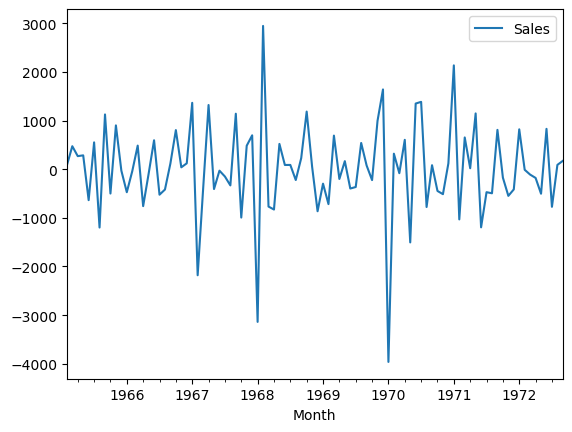

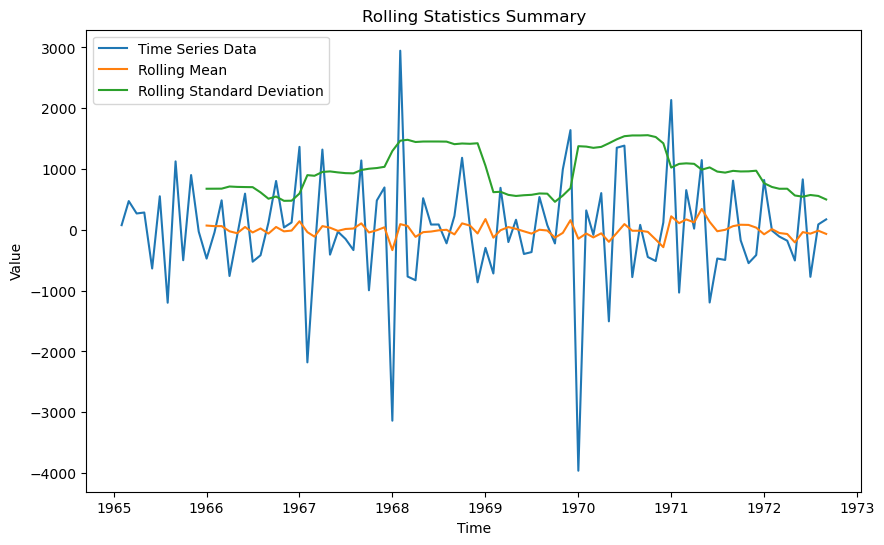

In [21]:
# we see that our time series data is now stationary - let us plot it to confirm 
df_diff.plot()
check_roll_stats(df_diff)

### ARIMA & SARIMAX Modeling

<Figure size 1200x400 with 0 Axes>

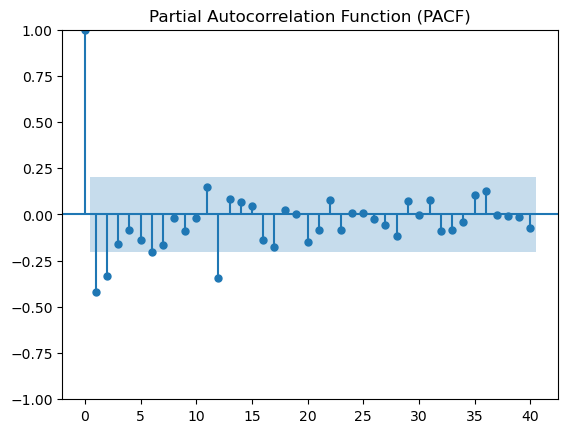

<Figure size 1200x400 with 0 Axes>

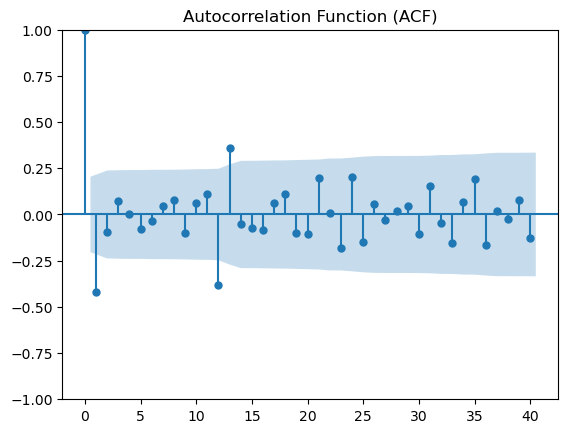

In [22]:
# generate the PACF and ACF plots to determine the p and q components for AR and MA models respectively 
# look for order where there's abrupt drop in PACF & exponential drop in ACF 

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# PACF plot 
plt.figure(figsize=(12, 4))
plot_pacf(df_diff, lags=40, title='Partial Autocorrelation Function (PACF)')
plt.show()

# ACF plot - take the value where the curve cuts 0 
plt.figure(figsize=(12, 4))
plot_acf(df_diff, lags=40, title='Autocorrelation Function (ACF)')
plt.show()

# Based on PACF/ACF observation, lets pick p = 1 , q = 0 (we can also take q = 1 and see which value works better) 

In [23]:
# split data into training and testing sets 

pct_training_data = 0.70

trn_len = int(len(df)* pct_training_data)
df_train, df_test = df.iloc[:trn_len,:], df.iloc[trn_len:,:]

In [24]:
import statsmodels.api as sm

# p,d,q values 
order_ = (1,1,0)

arima = sm.tsa.ARIMA(df_train, order= order_)
res_arima = arima.fit()

# function to calculate MSE (Error Metric) 
def calc_mse(df_test,df_pred):
    error = (df_test.Sales - df_pred)
    mse = round(math.sqrt(sum(error**2))/len(df_test),2)
    print(f"\nRMSE value:{mse}")

# arima_pred = res_arima.get_forecast(steps=len(df_test)).predicted_mean
forecast_arima = res_arima.forecast(steps= len(df_test))
calc_mse(df_test, forecast_arima)

# Since ARIMA works better for non-seasonal data, and ours is seasonal, let's also train SARIMAX model to see the performance difference
s_order = (1,1,1,12)
sarimax = sm.tsa.SARIMAX(df_train, order= order_,  seasonal_order= s_order)
res_sarimax = sarimax.fit()
forecast_sarimax = res_sarimax.get_forecast(steps=len(df_test)).predicted_mean
calc_mse(df_test, forecast_sarimax)

df['ARIMA_prediction'], df['SARIMAX_prediction'] = forecast_arima, forecast_sarimax


RMSE value:567.98
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.89843D+00    |proj g|=  5.23961D-01

At iterate    5    f=  6.75575D+00    |proj g|=  5.94968D-03

At iterate   10    f=  6.75482D+00    |proj g|=  7.37294D-05

At iterate   15    f=  6.75481D+00    |proj g|=  1.28046D-03

At iterate   20    f=  6.75460D+00    |proj g|=  1.39255D-02

At iterate   25    f=  6.75321D+00    |proj g|=  4.69496D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value


RMSE value:147.17
           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   

 This problem is unconstrained.


In [29]:
# show final results 
df

,Sales,ARIMA_prediction,SARIMAX_prediction
Month,,,
1964-01-01,2815,NaN,NaN
1964-02-01,2672,NaN,NaN
1964-03-01,2755,NaN,NaN
1964-04-01,2721,NaN,NaN
1964-05-01,2946,NaN,NaN
...,...,...,...
1972-05-01,4618,3408.02635,4953.295939
1972-06-01,5312,3408.02635,4790.094347
1972-07-01,4298,3408.02635,3659.317079


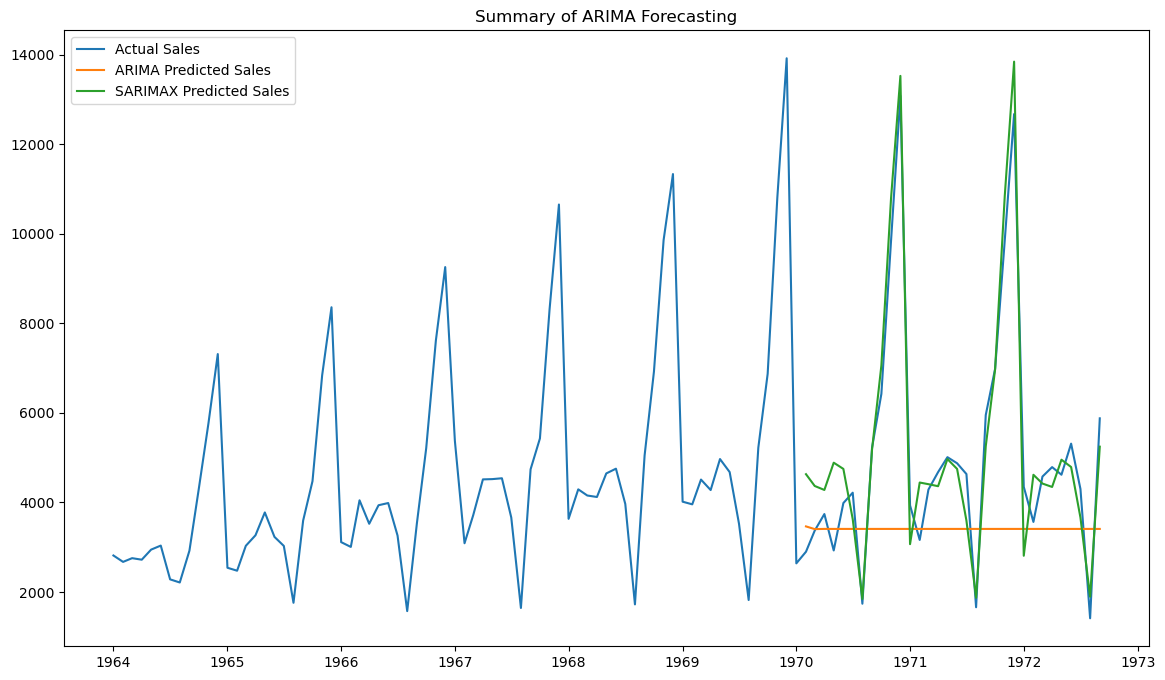

In [25]:
# plot the forecasted values against ground truth 

plt.figure(figsize = (14,8))
plt.plot(df.Sales, label = 'Actual Sales')
plt.plot(df.ARIMA_prediction, label = 'ARIMA Predicted Sales')
plt.plot(df.SARIMAX_prediction, label = 'SARIMAX Predicted Sales')
plt.legend()
plt.title('Summary of ARIMA Forecasting')
plt.show()